## Pushshift subreddit prediction

In [1]:
run_colab = False

In [2]:
if run_colab:
  !pip install transformers

In [17]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Input
from transformers import TFDistilBertModel
import glob
if run_colab:
  from google.colab import drive
else: 
  from tools.datasets import load_datasets
  from tools.datasets import load_tfrecord_nn1

In [4]:
if run_colab:
  drive.mount('/content/drive/')
  %cd 'drive/My Drive/personality_reddit'
  from tools.datasets import load_tfrecord_nn1

## General settings

Define model parameters

In [5]:
n_classes = 500
embed_dim = 768
seq_length = 512

Define models used to encode text. <br> We use HuggingFace's DistilBert (but other options are possible), which has an encoding size of 768 dimensions and a max sequence length of 512.

In [6]:
encoder_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In all models, we will need to encode posts by passing them to DistilBert. <br> 
For each token-by-token encoding, we need to only extract the representation of the `[CLS]` token. <br> 
To do so, we need to define a custom layer.

In [7]:
class CustomBertLayer(keras.Model):
  def __init__(self, model, name=None, trainable=True):
    super(CustomBertLayer, self).__init__(name=name)
    self.model = model
    self.trainable = trainable
    self.output_signature = tf.float32

  def call(self, input):
    enc = tf.map_fn(lambda x: self.model({'input_ids': x[0], 
                                          'attention_mask': x[1]})[0][:,0,:],
                    elems=tuple(input), 
                    dtype=self.output_signature)
    return enc

Here, we set a parameter determining whether the Bert layer can be fine-tuned

In [8]:
encoder_model.trainable = False
bert_trainable = encoder_model.trainable

## Network 1
Predict all subreddits from matrix. <br>
We will first encode all posts using DistilBert, then pass the stacked CLS encodings for a certain user to a further transformer layer. <br>
We will then build a classifier on top of transformer layer, which yields one score per word.

In [9]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, name=None, rate=0.1):
        super(TransformerBlock, self).__init__(name=name)
        self.att = layers.Attention() # self-attention?
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att([inputs, inputs])
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [10]:
class ClassificationBlock(layers.Layer):
    def __init__(self, relu_dim, n_classes, name=None):
        super(ClassificationBlock, self).__init__(name=name)
        self.ffn = keras.Sequential(
            [layers.Dense(relu_dim, activation="relu"), 
            layers.Dense(n_classes, activation="softmax")]
        )

    def call(self, inputs):
        return self.ffn(inputs)

Build the model

In [11]:
input_ids = Input(shape=(None, seq_length), dtype='int32', name='input_ids')
attention_ids = Input(shape=(None, seq_length), dtype='int32', name='attention_mask')

encoder_block = CustomBertLayer(encoder_model, name='encoder', trainable=bert_trainable)
encodings = encoder_block([input_ids, attention_ids])

transformer_block = TransformerBlock(embed_dim=embed_dim, ff_dim=32, name='transformer')
encodings_transformer = transformer_block(encodings)

predictions = ClassificationBlock(relu_dim=32, n_classes=n_classes, name='one_hot_subreddit')(encodings_transformer)
model = keras.Model([input_ids, attention_ids], predictions)

Instructions for updating:
Use fn_output_signature instead


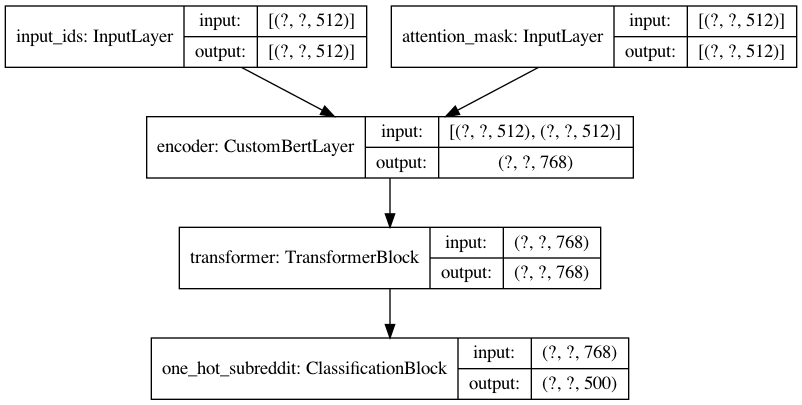

In [12]:
keras.utils.plot_model(model, "nn1.png", show_shapes=True)

In [13]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, None, 512)]  0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, None, 512)]  0                                            
__________________________________________________________________________________________________
encoder (CustomBertLayer)       (None, None, 768)    66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
transformer (TransformerBlock)  (None, None, 768)    53024       encoder[0][0]         

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

Read in the dataset

In [15]:
fnames = glob.glob('datasets/test/*')

In [24]:
ds = load_tfrecord_nn1(filenames=fnames, compression_type='GZIP')

Fit the model

In [25]:
# data streaming ideas?

In [26]:
history = model.fit(ds.take(2).batch(1), epochs=2, verbose=1)

Epoch 1/2
2/2 [==============================] - 15s 8s/step - loss: 6.4257 - categorical_accuracy: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 17s 8s/step - loss: 6.4035 - categorical_accuracy: 0.0000e+00


In [ ]:
# Check accuracy values?